# Deloitte Exercise

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Reading in Data

- Encoding error for the male race data. Needed to change read encoding, as there was an invalid bit for utf-8, so ISO latin-1 will handle it.

In [2]:
f_data = pd.read_table("MA_Exer_PikesPeak_Females.txt", encoding = 'latin-1')

In [3]:
m_data = pd.read_table("MA_Exer_PikesPeak_Males.txt", encoding = 'latin-1')

## Combining Data
- Combining Male and Female Data
- Adding Gender Column

In [4]:
m_data['gender'] = 'M'
f_data['gender'] = 'F'
all_data = pd.concat([f_data, m_data], ignore_index = True)

In [5]:
all_data.head()

,Place,Div/Tot,Num,Name,Ag,Hometown,Gun Tim,Net Tim,Pace,gender
0,1,1/86,30,Florence Jepkosgei,22.0,Kenya .,32:59,32:58#,5:19,F
1,2,2/86,8,Eunice Chepkirui,21.0,Kenya .,33:14,33:13#,5:21,F
2,3,1/247,3200,Elena Orlova,36.0,Gaithersburg MD,34:26,34:25#,5:33,F
3,4,1/173,2,Susannah Kvasnicka,34.0,Great Falls VA,34:43,34:42#,5:35,F
4,5,1/142,6,Casey Smith,26.0,Arlington VA,35:04,35:02,5:39,F


## Data Problems

### Missing Values

In [6]:
all_data[all_data.isna().apply(lambda x: any(x), axis = 1)]

,Place,Div/Tot,Num,Name,Ag,Hometown,Gun Tim,Net Tim,Pace,gender
964,965,NaN,201,Carla Sabloff,0.0,Mclean VA,1:13:38,1:08:29,11:02,F
979,980,NaN,2843,Susan Rasmussen,NaN,Gaithersburg MD,1:14:51,1:09:34,11:12,F
1630,526,NaN,2003,Chris Nash,0.0,Brookeville MD,51:04,49:35,7:59,M
1829,725,NaN,1999,Alan Nadelbach,NaN,Columbia MD,54:16,52:56,8:32,M


#### Missing Div/Tot
There are empty Div/Tot values for some runners. If there were runners with missing Div/Tot that had a correctly formatted Ag, then we may be able to reverse engineer this. This column isn't too important however, since the main column important to division-wise aggregations will be the Age.

In [7]:
all_data[all_data['Div/Tot'].isna()]

,Place,Div/Tot,Num,Name,Ag,Hometown,Gun Tim,Net Tim,Pace,gender
964,965,NaN,201,Carla Sabloff,0.0,Mclean VA,1:13:38,1:08:29,11:02,F
979,980,NaN,2843,Susan Rasmussen,NaN,Gaithersburg MD,1:14:51,1:09:34,11:12,F
1630,526,NaN,2003,Chris Nash,0.0,Brookeville MD,51:04,49:35,7:59,M
1829,725,NaN,1999,Alan Nadelbach,NaN,Columbia MD,54:16,52:56,8:32,M


#### Missing / Invalid Ages
Where there are incorrect ages, we can try to guess the age group from the Div/Total column. We may be able to find and categorize these missing runners into a division to include them in division-wise aggregations. However, for the ones with missing from both, we won't ALWAYS be able to put them in a division.

However, in our case, for both Male and Female groups, 2/3 of the missing runners seem to be from the same division, and the leftover runner can be placed into the Div/Tot group that is missing one runner.

In [8]:
all_data[(all_data['Ag'] <= 0) | all_data['Ag'].isna()]

,Place,Div/Tot,Num,Name,Ag,Hometown,Gun Tim,Net Tim,Pace,gender
382,383,4/15,1917,Stefanie Merritt,-1.0,Alexandria VA,55:33,54:22*,8:45,F
964,965,NaN,201,Carla Sabloff,0.0,Mclean VA,1:13:38,1:08:29,11:02,F
979,980,NaN,2843,Susan Rasmussen,NaN,Gaithersburg MD,1:14:51,1:09:34,11:12,F
1008,1009,15/15,1778,Susan Mackey,-1.0,North Potomac M,D 1:16:36,1:11:18*,11:29,F
1630,526,NaN,2003,Chris Nash,0.0,Brookeville MD,51:04,49:35,7:59,M
1829,725,NaN,1999,Alan Nadelbach,NaN,Columbia MD,54:16,52:56,8:32,M
1896,792,15/28,1555,Jon Kesler,-1.0,Silver Spring MD,59:20,54:06,8:43,M
2314,1210,26/28,556,Chris Barr,-1.0,Germantown MD,1:15:39,1:10:30,11:21,M


However! Upon further inspection, we can see that that no categories seem to be missing runners. Thus the runners with no Div/Tot will just be missing the division. In aggregation over Male and Female runners, their data will be used, but in the division-wise aggregation, they will be in their own missing group.

In [9]:
all_data[['Div', 'Tot']] = (
    all_data['Div/Tot'].apply(lambda x: pd.Series([np.nan, np.nan]) if str(x) == 'nan' else pd.Series(x.split('/')).astype(float))
)
div_counts = all_data.groupby(['Tot', 'gender'], as_index = False)['Num'].agg('count')
div_counts['deduped_num'] = div_counts['Num'] / (div_counts['Num'] / div_counts['Tot'])
div_counts['diffs'] = div_counts['deduped_num'] - div_counts['Tot']
div_counts['diffs'].mean()

0.0

### Time Misformattings

Gun Tim, and Net Tim both have special characters besides the actual time. We must remove these from the strings, and format our time strings correctly so that we can correctly analyze these.

In [10]:
all_data[['Gun Tim', 'Net Tim']].head()

,Gun Tim,Net Tim
0,32:59,32:58#
1,33:14,33:13#
2,34:26,34:25#
3,34:43,34:42#
4,35:04,35:02


### Cleaning
- Removing missing Div/Tot runners as discussed above
- Need to clean time columns of special characters.
- Setting incorrect Ages to NA
- Converting time columns into seconds for easier calculations


In [11]:
# all_data = all_data[~all_data['Div/Tot'].isna()]

In [12]:
clean_times = lambda x: x.str.replace('[^0-9:]', '') 

all_data['Net Tim'] = clean_times(all_data['Net Tim'])
all_data['Gun Tim'] = clean_times(all_data['Gun Tim'])
all_data['Pace'] = clean_times(all_data['Pace'])

In [13]:
all_data['Ag'] = all_data['Ag'].apply(lambda x: np.nan if (x < 1) or np.isnan(x) else x)

In [14]:
def make_seconds(time_str):
    if len(time_str) == 0 or time_str is None:
        return 0
    
    split_time = time_str.split(':')
    return np.sum([(60 ** (len(split_time) - idx - 1)) * int(t) for idx, t in enumerate(split_time)])
    
all_data['net_time_s'] = all_data['Net Tim'].apply(make_seconds)
all_data['gun_time_s'] = all_data['Gun Tim'].apply(make_seconds)
all_data['pace_s'] = all_data['Pace'].apply(make_seconds)

In [15]:
all_data

,Place,Div/Tot,Num,Name,Ag,Hometown,Gun Tim,Net Tim,Pace,gender,Div,Tot,net_time_s,gun_time_s,pace_s
0,1,1/86,30,Florence Jepkosgei,22.0,Kenya .,32:59,32:58,5:19,F,1.0,86.0,1978,1979,319
1,2,2/86,8,Eunice Chepkirui,21.0,Kenya .,33:14,33:13,5:21,F,2.0,86.0,1993,1994,321
2,3,1/247,3200,Elena Orlova,36.0,Gaithersburg MD,34:26,34:25,5:33,F,1.0,247.0,2065,2066,333
3,4,1/173,2,Susannah Kvasnicka,34.0,Great Falls VA,34:43,34:42,5:35,F,1.0,173.0,2082,2083,335
4,5,1/142,6,Casey Smith,26.0,Arlington VA,35:04,35:02,5:39,F,1.0,142.0,2102,2104,339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2365,1261,200/201,2792,Kenneth Winkfield,49.0,Bowie MD,1:35:50,1:30:29,14:34,M,200.0,201.0,5429,5750,874
2366,1262,50/50,63,Thom Hunter,63.0,Gaithersburg MD,1:42:41,1:37:20,15:40,M,50.0,50.0,5840,6161,940
2367,1263,96/96,1547,Nicholas Kelsch,27.0,Gaithersburg MD,1:43:00,1:37:50,15:45,M,96.0,96.0,5870,6180,945
2368,1264,201/201,3330,Cliff Chiet,45.0,Gaithersburg MD,1:44:07,1:38:46,15:54,M,201.0,201.0,5926,6247,954


### Augmenting
- Imputing Age for missing Ages from Div/Tot and Gender
- Creating Age Buckets for the Division Definitions
- Converting seconds to python timedelta object
- Adding city and states

Note: In this data, the groups which the missing age runners are in, have a distinct total number of runners. In the case where the divisions had equal total counts, there may not always be a way to find then exact age group. This could happen if the two divisions are both missing runners. We could find it in the case where there are multiple divisions with the same total counts if only one is missing runners.

In [16]:
all_data[all_data.apply(lambda x: any(x.isna()), axis = 1)]

,Place,Div/Tot,Num,Name,Ag,Hometown,Gun Tim,Net Tim,Pace,gender,Div,Tot,net_time_s,gun_time_s,pace_s
382,383,4/15,1917,Stefanie Merritt,NaN,Alexandria VA,55:33,54:22,8:45,F,4.0,15.0,3262,3333,525
964,965,NaN,201,Carla Sabloff,NaN,Mclean VA,1:13:38,1:08:29,11:02,F,NaN,NaN,4109,4418,662
979,980,NaN,2843,Susan Rasmussen,NaN,Gaithersburg MD,1:14:51,1:09:34,11:12,F,NaN,NaN,4174,4491,672
1008,1009,15/15,1778,Susan Mackey,NaN,North Potomac M,1:16:36,1:11:18,11:29,F,15.0,15.0,4278,4596,689
1630,526,NaN,2003,Chris Nash,NaN,Brookeville MD,51:04,49:35,7:59,M,NaN,NaN,2975,3064,479
1829,725,NaN,1999,Alan Nadelbach,NaN,Columbia MD,54:16,52:56,8:32,M,NaN,NaN,3176,3256,512
1896,792,15/28,1555,Jon Kesler,NaN,Silver Spring MD,59:20,54:06,8:43,M,15.0,28.0,3246,3560,523
2314,1210,26/28,556,Chris Barr,NaN,Germantown MD,1:15:39,1:10:30,11:21,M,26.0,28.0,4230,4539,681


In [17]:
def get_ages(row):
    if np.isnan(row['Tot']):
        return np.nan
    
    avg_age = (
        all_data[
            (all_data['Tot'] == row['Tot']) & (all_data['gender'] == row['gender'])
        ]['Ag']
        .mean()
    )
    
    return int(avg_age)

In [18]:
all_data.loc[all_data['Ag'].isna(), 'Ag'] = all_data[all_data['Ag'].isna()].apply(get_ages, axis = 1)

In [19]:
all_data[all_data.apply(lambda x: any(x.isna()), axis = 1)]

,Place,Div/Tot,Num,Name,Ag,Hometown,Gun Tim,Net Tim,Pace,gender,Div,Tot,net_time_s,gun_time_s,pace_s
964,965,NaN,201,Carla Sabloff,NaN,Mclean VA,1:13:38,1:08:29,11:02,F,NaN,NaN,4109,4418,662
979,980,NaN,2843,Susan Rasmussen,NaN,Gaithersburg MD,1:14:51,1:09:34,11:12,F,NaN,NaN,4174,4491,672
1630,526,NaN,2003,Chris Nash,NaN,Brookeville MD,51:04,49:35,7:59,M,NaN,NaN,2975,3064,479
1829,725,NaN,1999,Alan Nadelbach,NaN,Columbia MD,54:16,52:56,8:32,M,NaN,NaN,3176,3256,512


In [20]:
def assign_age_group(age):
    fmt_div_string = lambda ages: "{} - {}".format(*ages)
    if np.isnan(age):
        return 'Missing Division'
    if age <=14:
        return fmt_div_string([0, 14])
    if 15 <= age <= 19:
        return fmt_div_string([15, 19])
    div_num = int(10 * (age // 10))
    return fmt_div_string([div_num, div_num + 9])

In [21]:
all_data['age_group'] = all_data['Ag'].apply(assign_age_group)

A final look at our cleaned, and augmented dataset

In [22]:
all_data.head()

,Place,Div/Tot,Num,Name,Ag,Hometown,Gun Tim,Net Tim,Pace,gender,Div,Tot,net_time_s,gun_time_s,pace_s,age_group
0,1,1/86,30,Florence Jepkosgei,22.0,Kenya .,32:59,32:58,5:19,F,1.0,86.0,1978,1979,319,20 - 29
1,2,2/86,8,Eunice Chepkirui,21.0,Kenya .,33:14,33:13,5:21,F,2.0,86.0,1993,1994,321,20 - 29
2,3,1/247,3200,Elena Orlova,36.0,Gaithersburg MD,34:26,34:25,5:33,F,1.0,247.0,2065,2066,333,30 - 39
3,4,1/173,2,Susannah Kvasnicka,34.0,Great Falls VA,34:43,34:42,5:35,F,1.0,173.0,2082,2083,335,30 - 39
4,5,1/142,6,Casey Smith,26.0,Arlington VA,35:04,35:02,5:39,F,1.0,142.0,2102,2104,339,20 - 29


In [23]:
to_time_fmt = lambda x: dt.timedelta(seconds = int(x))

In [24]:
all_data['gun_time'] = all_data['gun_time_s'].apply(to_time_fmt)
all_data['net_time'] = all_data['net_time_s'].apply(to_time_fmt)
all_data['pace_time'] = all_data['pace_s'].apply(to_time_fmt)

In [25]:
all_data[['city','state']] = all_data['Hometown'].apply(lambda x: pd.Series([" ".join(x.split(' ')[0:-1]), x.split(' ')[-1]]))

In [26]:
all_data['division'] = all_data['gender'] + ' - ' + all_data['age_group']

In [27]:
all_data.head()

,Place,Div/Tot,Num,Name,Ag,Hometown,Gun Tim,Net Tim,Pace,gender,...,net_time_s,gun_time_s,pace_s,age_group,gun_time,net_time,pace_time,city,state,division
0,1,1/86,30,Florence Jepkosgei,22.0,Kenya .,32:59,32:58,5:19,F,...,1978,1979,319,20 - 29,00:32:59,00:32:58,00:05:19,Kenya,.,F - 20 - 29
1,2,2/86,8,Eunice Chepkirui,21.0,Kenya .,33:14,33:13,5:21,F,...,1993,1994,321,20 - 29,00:33:14,00:33:13,00:05:21,Kenya,.,F - 20 - 29
2,3,1/247,3200,Elena Orlova,36.0,Gaithersburg MD,34:26,34:25,5:33,F,...,2065,2066,333,30 - 39,00:34:26,00:34:25,00:05:33,Gaithersburg,MD,F - 30 - 39
3,4,1/173,2,Susannah Kvasnicka,34.0,Great Falls VA,34:43,34:42,5:35,F,...,2082,2083,335,30 - 39,00:34:43,00:34:42,00:05:35,Great Falls,VA,F - 30 - 39
4,5,1/142,6,Casey Smith,26.0,Arlington VA,35:04,35:02,5:39,F,...,2102,2104,339,20 - 29,00:35:04,00:35:02,00:05:39,Arlington,VA,F - 20 - 29


## 1. What are the mean, median, mode, and range of the race results for all racers, by gender?

In [28]:
def get_race_stats(col):
    get_modes = lambda x: ", ".join([str(to_time_fmt(m)) for m in pd.Series.mode(x).astype(str).values])
    stats = (
        all_data
        .groupby('gender')[col]
        .agg(['mean', 'median', 'max', 'min', get_modes])
        .rename(columns = {"<lambda_0>": "modes"})
    )   
    
    
    stats['range'] = (stats['max'] - stats['min'])
    stats[['mean', 'median', 'max', 'min', 'range']] = stats[['mean', 'median', 'max', 'min', 'range']].applymap(lambda x: str(to_time_fmt(x)))
    
    return stats

In [32]:
def get_race_stats_old(col):
    get_modes = lambda x: ", ".join([str(to_time_fmt(m)) for m in pd.Series.mode(x).astype(str).values])
    stats = (
        all_data
        .groupby('gender')[col]
        .agg(['mean', 'median', 'max', 'min', get_modes])
        .rename(columns = {"<lambda_0>": "modes"})
    )   
    
    
    stats['range'] = (stats['max'] - stats['min'])
    stats[['mean', 'median', 'max', 'min', 'range']] = stats[['mean', 'median', 'max', 'min', 'range']].applymap(to_time_fmt)
    
    return stats

In [33]:
net_stats = get_race_stats('net_time_s').reset_index()
net_stats.T.astype(str)
# net_stats

,0,1
gender,F,M
mean,0:58:28,0:52:07
median,0:57:51,0:51:23
max,1:46:49,1:40:38
min,0:32:58,0:28:47
modes,"0:48:06, 0:51:35, 0:52:59, 0:53:29, 0:59:00","0:35:28, 0:47:05, 0:47:23, 0:49:48, 0:49:58, 0..."
range,1:13:51,1:11:51


In [34]:
net_stats = get_race_stats_old('net_time_s').reset_index()

In [35]:
net_stats['mean_secs'] = net_stats['mean'].apply(lambda x: x.total_seconds())
net_stats['med_secs'] = net_stats['median'].apply(lambda x: x.total_seconds())
net_stats['max_secs'] = net_stats['max'].apply(lambda x: x.total_seconds())
net_stats['min_secs'] = net_stats['min'].apply(lambda x: x.total_seconds())

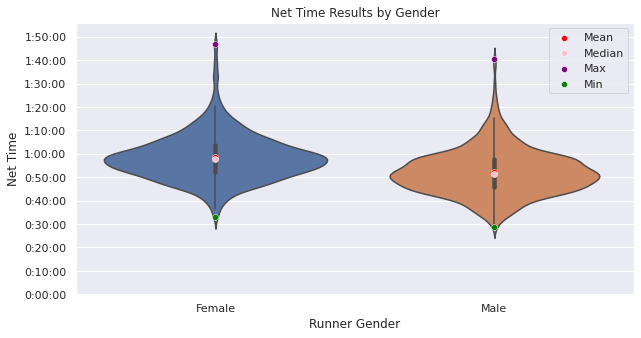

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.scatterplot(x = 'gender', y = 'mean_secs', color = 'red', data = net_stats, label = 'Mean', zorder = 10, ax = ax)
ax = sns.scatterplot(x = 'gender', y = 'med_secs', color = 'pink', data = net_stats, label = 'Median', zorder = 10, ax = ax)
ax = sns.scatterplot(x = 'gender', y = 'max_secs', color = 'purple', data = net_stats, label = 'Max', zorder = 10, ax = ax)
ax = sns.scatterplot(x = 'gender', y = 'min_secs', color = 'green', data = net_stats, label = 'Min', zorder = 10, ax = ax)
ax = sns.violinplot(x = 'gender', y = 'net_time_s', data = all_data, ax = ax)

y_ticks = [tick for tick in np.arange(2 * 60 * 60, step = 10 * 60)]
y_ticklabels = [str(to_time_fmt(tick)) for tick in y_ticks]

ax.legend()
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticklabels)
ax.set_xticklabels(['Female', 'Male'])

ax.set_ylabel("Net Time")
ax.set_xlabel("Runner Gender")
ax.set_title("Net Time Results by Gender");

## 2. Analyze the difference between gun and net time race results.

In [37]:
all_data['time_diff_s'] = all_data['gun_time_s'] - all_data['net_time_s']
all_data['time_diff'] = all_data['time_diff_s'].apply(to_time_fmt)

In [38]:
all_data

,Place,Div/Tot,Num,Name,Ag,Hometown,Gun Tim,Net Tim,Pace,gender,...,pace_s,age_group,gun_time,net_time,pace_time,city,state,division,time_diff_s,time_diff
0,1,1/86,30,Florence Jepkosgei,22.0,Kenya .,32:59,32:58,5:19,F,...,319,20 - 29,00:32:59,00:32:58,00:05:19,Kenya,.,F - 20 - 29,1,00:00:01
1,2,2/86,8,Eunice Chepkirui,21.0,Kenya .,33:14,33:13,5:21,F,...,321,20 - 29,00:33:14,00:33:13,00:05:21,Kenya,.,F - 20 - 29,1,00:00:01
2,3,1/247,3200,Elena Orlova,36.0,Gaithersburg MD,34:26,34:25,5:33,F,...,333,30 - 39,00:34:26,00:34:25,00:05:33,Gaithersburg,MD,F - 30 - 39,1,00:00:01
3,4,1/173,2,Susannah Kvasnicka,34.0,Great Falls VA,34:43,34:42,5:35,F,...,335,30 - 39,00:34:43,00:34:42,00:05:35,Great Falls,VA,F - 30 - 39,1,00:00:01
4,5,1/142,6,Casey Smith,26.0,Arlington VA,35:04,35:02,5:39,F,...,339,20 - 29,00:35:04,00:35:02,00:05:39,Arlington,VA,F - 20 - 29,2,00:00:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2365,1261,200/201,2792,Kenneth Winkfield,49.0,Bowie MD,1:35:50,1:30:29,14:34,M,...,874,40 - 49,01:35:50,01:30:29,00:14:34,Bowie,MD,M - 40 - 49,321,00:05:21
2366,1262,50/50,63,Thom Hunter,63.0,Gaithersburg MD,1:42:41,1:37:20,15:40,M,...,940,60 - 69,01:42:41,01:37:20,00:15:40,Gaithersburg,MD,M - 60 - 69,321,00:05:21
2367,1263,96/96,1547,Nicholas Kelsch,27.0,Gaithersburg MD,1:43:00,1:37:50,15:45,M,...,945,20 - 29,01:43:00,01:37:50,00:15:45,Gaithersburg,MD,M - 20 - 29,310,00:05:10
2368,1264,201/201,3330,Cliff Chiet,45.0,Gaithersburg MD,1:44:07,1:38:46,15:54,M,...,954,40 - 49,01:44:07,01:38:46,00:15:54,Gaithersburg,MD,M - 40 - 49,321,00:05:21


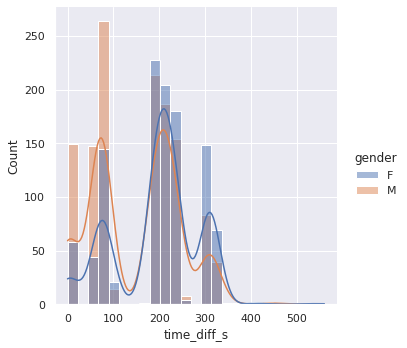

In [39]:
sns.displot(data = all_data, x = 'time_diff_s', hue = 'gender', kde = True)

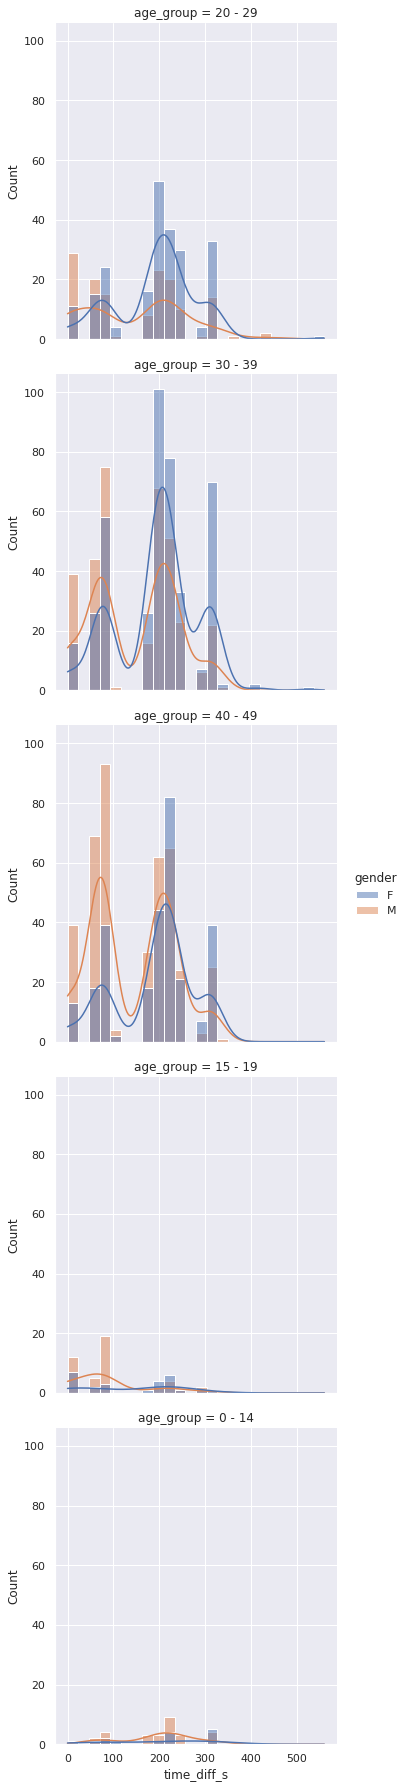

In [40]:
sns.displot(data = all_data[all_data['Ag'] < 50], x = 'time_diff_s', hue = 'gender', kde = True, row = 'age_group')

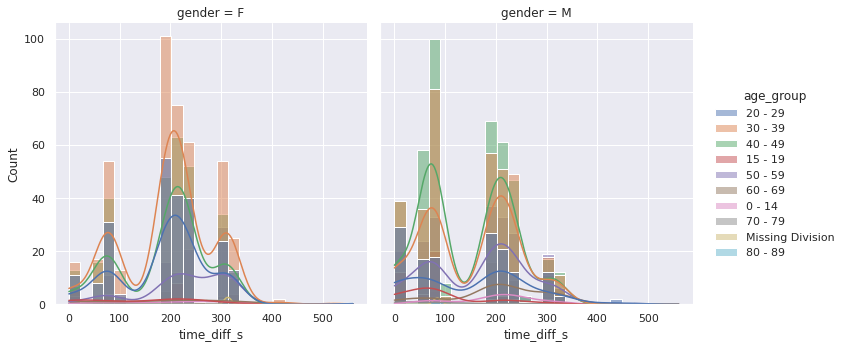

In [42]:
plts = sns.displot(data = all_data, x = 'time_diff_s', hue = 'age_group', kde = True, col = 'gender')

In [43]:
pd.pivot_table(all_data, index = ['age_group'], columns = ['gender'], values = 'time_diff_s', aggfunc = ['mean', 'min', 'max', 'count'], dropna = False, fill_value = 0)

mean              min      max      count     
gender                     F           M    F   M    F    M     F    M
age_group                                                             
0 - 14            199.466667  196.464286    5  63  318  314    15   28
15 - 19           137.461538   86.355556    1   0  308  303    26   45
20 - 29           193.179825  147.965278    1   0  560  442   228  144
30 - 39           195.597619  148.546243    0   0  524  332   420  346
40 - 49           190.600707  142.889157    1   0  326  334   283  415
50 - 59           228.278846  163.673171    2   0  318  469   104  205
60 - 69           176.458333  201.666667    4   0  323  347    24   69
70 - 79            81.000000   78.222222    1   3  236  246     3    9
80 - 89             0.000000  154.500000    0   5    0  304     0    2
Missing Division  313.000000   84.500000  309  80  317   89     2    2

The average difference seems to be lowest amongst the 70-79 year old groups. This is most likely due to their low population -- i.e a sparse population of the starting area. The 15-19 year old males is very close to that, despite there being 45 runners. Could be due to the highly competitive nature of the young male age group?

## 3. How much time separates Chris Doe from the top 10 percentile of racers of the same division?

In [44]:
chris_div = all_data[all_data['Name'] == 'Chris Doe']['age_group'].values[0]
chris_gender = all_data[all_data['Name'] == 'Chris Doe']['gender'].values[0]
chris_time = all_data[all_data['Name'] == 'Chris Doe']['net_time_s'].values[0]
chris_data = all_data[(all_data['age_group'] == chris_div) & (all_data['gender'] == chris_gender)].copy()
chris = all_data[all_data['Name'] == 'Chris Doe'].copy()
chris_data

,Place,Div/Tot,Num,Name,Ag,Hometown,Gun Tim,Net Tim,Pace,gender,...,pace_s,age_group,gun_time,net_time,pace_time,city,state,division,time_diff_s,time_diff
1119,15,1/201,15,Mark Malander,48.0,Herndon VA,33:07,33:06,5:20,M,...,320,40 - 49,00:33:07,00:33:06,00:05:20,Herndon,VA,M - 40 - 49,1,00:00:01
1126,22,1/214,5,Darrell General,40.0,Bowie MD,34:03,34:02,5:29,M,...,329,40 - 49,00:34:03,00:34:02,00:05:29,Bowie,MD,M - 40 - 49,1,00:00:01
1127,23,2/214,1302,David Haaga,44.0,Rockville MD,34:11,34:10,5:30,M,...,330,40 - 49,00:34:11,00:34:10,00:05:30,Rockville,MD,M - 40 - 49,1,00:00:01
1129,25,2/201,41,George Buckheit,48.0,Reson VA,34:25,34:23,5:32,M,...,332,40 - 49,00:34:25,00:34:23,00:05:32,Reson,VA,M - 40 - 49,2,00:00:02
1135,31,3/214,2628,Derik Thomas,40.0,Alexandria VA,34:42,34:41,5:35,M,...,335,40 - 49,00:34:42,00:34:41,00:05:35,Alexandria,VA,M - 40 - 49,1,00:00:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2358,1254,199/201,1685,Byung Lee,48.0,Laurel MD,1:24:36,1:21:33,13:08,M,...,788,40 - 49,01:24:36,01:21:33,00:13:08,Laurel,MD,M - 40 - 49,183,00:03:03
2363,1259,213/214,1241,Kenape Gogo,41.0,Silver Spring MD,1:27:38,1:26:33,13:56,M,...,836,40 - 49,01:27:38,01:26:33,00:13:56,Silver Spring,MD,M - 40 - 49,65,00:01:05
2364,1260,214/214,1228,Neil Gilliam,40.0,Chevy Chase MD,1:32:44,1:29:37,14:26,M,...,866,40 - 49,01:32:44,01:29:37,00:14:26,Chevy Chase,MD,M - 40 - 49,187,00:03:07
2365,1261,200/201,2792,Kenneth Winkfield,49.0,Bowie MD,1:35:50,1:30:29,14:34,M,...,874,40 - 49,01:35:50,01:30:29,00:14:34,Bowie,MD,M - 40 - 49,321,00:05:21


In [45]:
str(to_time_fmt(np.percentile(chris_data['net_time_s'], 10)))

'0:41:41'

In [46]:
str(to_time_fmt(chris_time))

'0:49:43'

In [47]:
str(to_time_fmt(chris_time) - to_time_fmt(np.percentile(chris_data['net_time_s'], 10)))

'0:08:02'

Chris is about 8 minutes short from being in the 10th percentile.

In [48]:
((to_time_fmt(chris_time) - to_time_fmt(np.percentile(chris_data['net_time_s'], 10))).total_seconds() / 10)

48.2

In [49]:
# chris_data[chris_data['net_time_s'] <= np.percentile(chris_data['net_time_s'], 10)]

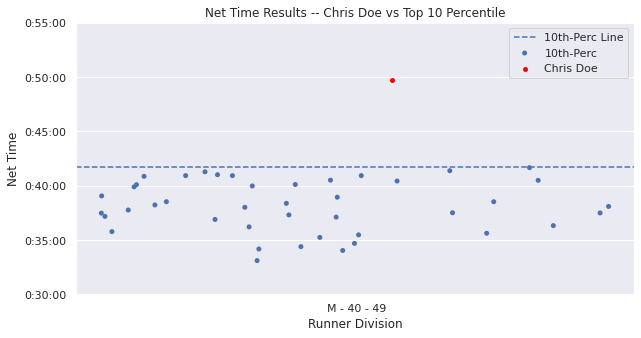

In [50]:
# chris_data['division'] = chris_data['gender'] + ' - ' + chris_data['age_group']
# chris['division'] = chris['gender'] + ' - ' + chris['age_group']

fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.stripplot(y = "net_time_s", x = 'division', data = chris_data[chris_data['net_time_s'] <= np.percentile(chris_data['net_time_s'], 10)], label = '10th-Perc', ax = ax)
ax = sns.stripplot(y = "net_time_s", x = 'division', color = 'Red', label = 'Chris Doe', data = chris, ax = ax)
ax.axhline(np.percentile(chris_data['net_time_s'], 10), ls='--', label = '10th-Perc Line')

y_ticks = [tick for tick in np.arange(start = 30 * 60, stop = 1 * 60 * 60, step = 5 * 60)]
y_ticklabels = [str(to_time_fmt(tick)) for tick in y_ticks]

ax.legend()
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticklabels)

ax.set_ylabel("Net Time")
ax.set_xlabel("Runner Division")
ax.set_title("Net Time Results -- Chris Doe vs Top 10 Percentile");

ax.legend();

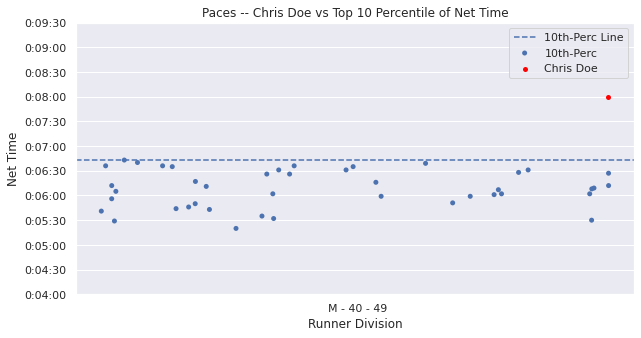

In [51]:
# chris_data['division'] = chris_data['gender'] + ' - ' + chris_data['age_group']
# chris['division'] = chris['gender'] + ' - ' + chris['age_group']

fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.stripplot(y = "pace_s", x = 'division', data = chris_data[chris_data['net_time_s'] <= np.percentile(chris_data['net_time_s'], 10)], label = '10th-Perc', ax = ax)
ax = sns.stripplot(y = "pace_s", x = 'division', color = 'Red', label = 'Chris Doe', data = chris, ax = ax)
ax.axhline(np.percentile(chris_data['pace_s'], 10), ls='--', label = '10th-Perc Line')

y_ticks = [tick for tick in np.arange(start = 4 * 60, stop = 10 * 60, step = 30)]
y_ticklabels = [str(to_time_fmt(tick)) for tick in y_ticks]

ax.legend()
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticklabels)

ax.set_ylabel("Net Time")
ax.set_xlabel("Runner Division")
ax.set_title("Paces -- Chris Doe vs Top 10 Percentile of Net Time");

ax.legend();

In other words, he needs to improve his pace by 48.2 seconds.

## 4. Compare the race results of each division

In [52]:
all_data.groupby(['gender', 'age_group'])['net_time_s'].agg(['mean', 'count'])

mean  count
gender age_group                           
F      0 - 14            3569.733333     15
       15 - 19           3127.846154     26
       20 - 29           3434.776316    228
       30 - 39           3522.166667    420
       40 - 49           3472.204947    283
       50 - 59           3756.653846    104
       60 - 69           3600.708333     24
       70 - 79           3846.666667      3
       Missing Division  4141.500000      2
M      0 - 14            3333.464286     28
       15 - 19           2799.266667     45
       20 - 29           2971.347222    144
       30 - 39           3099.312139    346
       40 - 49           3096.301205    415
       50 - 59           3235.546341    205
       60 - 69           3508.347826     69
       70 - 79           3555.555556      9
       80 - 89           4419.500000      2
       Missing Division  3075.500000      2

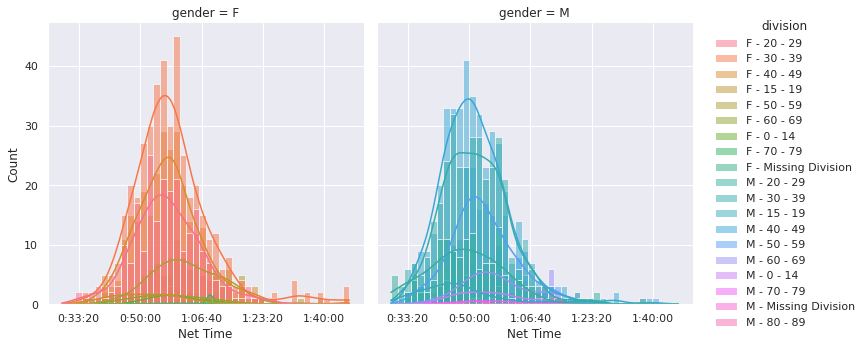

In [53]:
plts = sns.displot(data = all_data, x = 'net_time_s', hue = 'division', kde = True, col = 'gender')
for a in plts.axes:
    for b in a:
        x_ticklabels = [str(to_time_fmt(tick.get_text())) for tick in  b.get_xticklabels()]
        b.set_xticklabels(x_ticklabels)
        b.set_xlabel("Net Time");

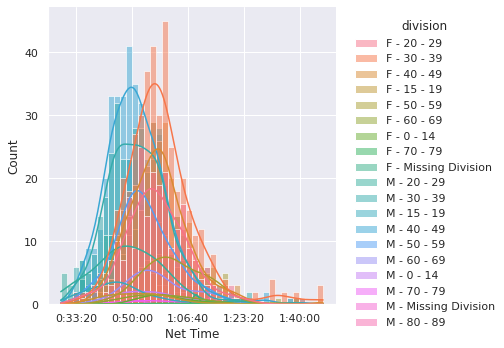

In [54]:
plts = sns.displot(data = all_data, x = 'net_time_s', hue = 'division', kde = True) 
for a in plts.axes:
    for b in a:
        x_ticklabels = [str(to_time_fmt(tick.get_text())) for tick in  b.get_xticklabels()]
        b.set_xticklabels(x_ticklabels)
        b.set_xlabel("Net Time");

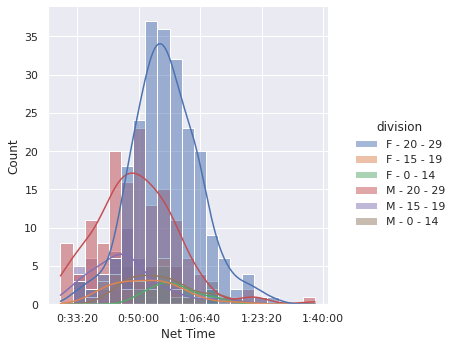

In [55]:
plts = sns.displot(data = all_data[all_data['Ag'] < 30], x = 'net_time_s', hue = 'division', kde = True)
for a in plts.axes:
    for b in a:
        x_ticklabels = [str(to_time_fmt(tick.get_text())) for tick in  b.get_xticklabels()]
        b.set_xticklabels(x_ticklabels)
        b.set_xlabel("Net Time");

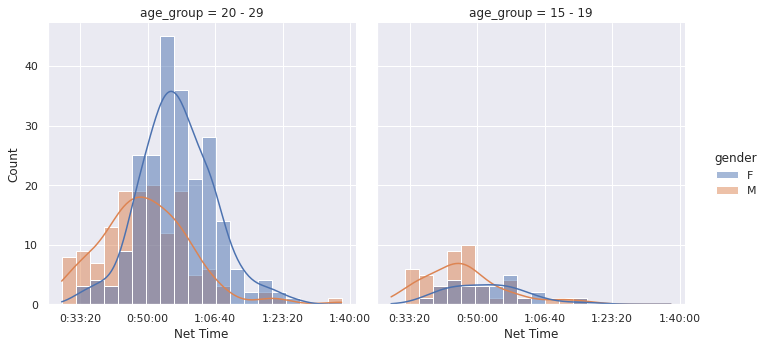

In [56]:
plts = sns.displot(data = all_data[(14 < all_data['Ag']) & (all_data['Ag'] < 30) ], x = 'net_time_s', hue = 'gender', col = 'age_group', kde = True)
for a in plts.axes:
    for b in a:
        x_ticklabels = [str(to_time_fmt(tick.get_text())) for tick in  b.get_xticklabels()]
        b.set_xticklabels(x_ticklabels)
        b.set_xlabel("Net Time");

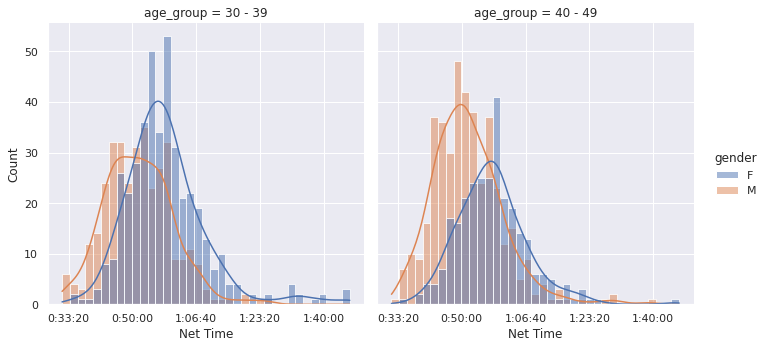

In [57]:
plts = sns.displot(data = all_data[(29 < all_data['Ag']) & (all_data['Ag'] < 50) ], x = 'net_time_s', hue = 'gender', col = 'age_group', kde = True)

for a in plts.axes:
    for b in a:
        x_ticklabels = [str(to_time_fmt(tick.get_text())) for tick in  b.get_xticklabels()]
        b.set_xticklabels(x_ticklabels)
        b.set_xlabel("Net Time");